# All Data - NLP EDA - NER on Company Names

This file doesn't run the NER, but does the plotting only

In [20]:
# Packages
import pandas as pd
import matplotlib.pyplot as plt
from stattotex import *

In [21]:
# Set output folder
output_folder = '../../../Output/All Data EDA/NLP EDA - NER on Company Names/'

In [22]:
# Load dataframe
# '../../../Data/Company_Mentions/Company_Mentions.parquet'
df = pd.read_parquet('../../../Data/Company_Mentions/Company_Mentions.parquet')
# Collapse to sum of count by ticker by fixed_quarter_date
df = df[['ticker', 'fixed_quarter_date', 'count']].groupby(['ticker', 'fixed_quarter_date']).sum().reset_index().rename(columns={'count': 'company_mentions'})
df

,ticker,fixed_quarter_date,company_mentions
0,AAPL,2014-07-01,112
1,AAPL,2014-10-01,122
2,AAPL,2015-01-01,87
3,AAPL,2015-04-01,83
4,AAPL,2015-07-01,83
...,...,...,...
6656,ZTS,2015-10-01,45
6657,ZTS,2016-01-01,107
6658,ZTS,2016-04-01,90
6659,ZTS,2016-07-01,75


In [23]:
# Limit to items in the finalized dataset
# list of files in '../../../Data/All_Data/All_Data_with_NLP_Features'
import os
file_list = [f for f in os.listdir(r'../../../Data/All_Data/All_Data_with_NLP_Features') if f.endswith('.parquet')]
# read in all parquet files
all_data_with_nlp_features_ticker_ecd = pd.concat([pd.read_parquet(r'../../../Data/All_Data/All_Data_with_NLP_Features/' + f, columns = ['ticker', 'fixed_quarter_date']) for f in file_list])
# Inner join with df
# Convert fixed_quarter_date to datetime in both dataframes
df['fixed_quarter_date'] = pd.to_datetime(df['fixed_quarter_date'])
all_data_with_nlp_features_ticker_ecd['fixed_quarter_date'] = pd.to_datetime(all_data_with_nlp_features_ticker_ecd['fixed_quarter_date'])
df = df.merge(all_data_with_nlp_features_ticker_ecd, on = ['ticker', 'fixed_quarter_date'], how = 'inner')

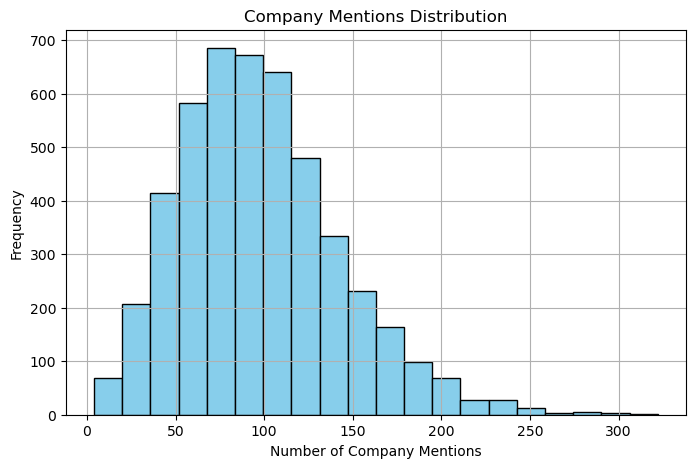

Average number of company mentions: 97.77815410668924


In [24]:
# Plot the distribution of company mentions
plt.figure(figsize=(8, 5))
plt.hist(df['company_mentions'], bins=20, color='skyblue', edgecolor='black')
plt.xlabel('Number of Company Mentions')
plt.ylabel('Frequency')
plt.grid(True)
# Output version with no title
plt.savefig(output_folder + 'Company Mentions Distribution No Title.png')
plt.title('Company Mentions Distribution')
plt.show()

print('Average number of company mentions:', df['company_mentions'].mean())

stattotex(round(df['company_mentions'].mean(), 2), 'avgCompanyMentions', output_folder + 'Company Mentions Average.tex')